# Gaps on structure functions: **interactive pipeline demo**
1. ~~Email Marcus~~
1. ~~Get heatmap importing and exporting~~
1. Plots
    - ~~MAPE in error trend line plots (means vs. means of means)? Using these in test set eval as well as determining bias initially?~~
    - ~~Add file indexing to later plots, move to appropriate locations.~~
    - ~~Get sample size plot (add *n* to heatmaps) Especially interested in how 3d heatmaps become more populated - *how often can test intervals not find the nearest bin?*~~
    - ~~Get plots to save.~~ Whereever we're saving things, run the os func to check folder exists
1. ~~Run for 2 PSP ints for training, 1 PSP for testing.~~ See what dfs we are left with, and export the final ones.
1. ~~Run for 1 Wind testing~~
1. Save and commit
2. Move concatenation, as done as at start of step 2, from start of step 3 to start of step 4. Make step 3 run *on each test set file individually*.
1. Divide each of the numbered steps into separate scripts. Note which we can use arrays for.
2. Test these locally: 3 and 2 PSPs, 2 Wind
1. Push (new repo?) to GitHub, clone to NeSI.
9. Quick scaling study on NeSI, investigating bad ints and possible automatic removal during download or initial reading
10. Results for 1 year of PSP, 1 month of Wind
10. Up the ante to two years, **while writing up existing results**. Maybe set aside geostats stuff for now.
11. Send manuscript to Tulasi, Fraternale, Marcus
12. Implement Fraternale's sample size threshold for fitting slopes

#### Notes
- Can add smoothing to correction step alter, **not on critical path for getting most of the scripts on NESI**
- Having logarithmically spaced lag bins would make the correction factor much cleaner to work with: one-to-one bins
- For now likely to do stick with simple job arrays and single jobs on HPC, with importing and exporting of intermediate steps, but perhaps better to do single MPI script with broadcasting and reducing.
- If we tend to just get one 1 interval out of each file, could do away with (file,int) indexing
- In either case, might using actual pandas indexes be easier/more efficient?
- Add sf slope to Wind dataset

In [1]:
# Selecting one file to read in
file_index = 0
times_to_gap = 3

# 1. Download files

Run in terminal

In [135]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

# 2. FOR EACH INTERVAL: standardise, duplicate, gap, calculate SFs

This will be distributed across job arrays on an HPC

## 2a. Import dependencies

In [1]:
import pickle
import pandas as pd
import numpy as np
import shutil
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="whitegrid", font_scale=1.5)
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

In [137]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

## 2b. Read in data and split into standardised intervals

Previously each core read in multiple files at a time. I think it will be better for each core to do one file at a time, especially given that each raw file contains sufficient *approximate* correlation lengths for us to then calculate the *local* outer scale and create our standardise intervals using that.

#### PSP data

In [67]:
raw_file_list = sorted(glob.iglob(f"data/raw/psp/" + "/*.cdf"))
raw_file_list

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf',
 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf',
 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']

In [70]:
psp_data = dif.read_cdfs(
    [raw_file_list[file_index]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B"].rename("B") # Giving generic name for spacecraft consistency
print("\n")
print(df_raw.info())

del psp_data, psp_data_ready, psp_df

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf
Done reading data


<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None


#### Wind data

In [64]:
raw_file_list = sorted(glob.iglob(f"data/raw/wind/" + "/*.cdf"))
raw_file_list

['data/raw/wind\\wi_h2_mfi_20160101_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160102_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160103_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160104_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160105_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160106_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160107_v05.cdf']

Not currently running (takes a while due to large files)

In [66]:
df = utils.pipeline(
    raw_file_list[file_index],
    varlist=sys_arg_dict["mag_vars"],
    thresholds=sys_arg_dict["mag_thresh"],
    cadence=sys_arg_dict["dt_hr"],
)

print("Reading {0}: {1:.1f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# Ensuring observations are in chronological order
df_wind_hr = df.sort_index()

# df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
df_wind_hr = df_wind_hr.rename(
    columns={
        params.Bwind: "Bwind",
        params.Bx: "Bx",
        params.By: "By",
        params.Bz: "Bz",
    }
)

missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

if missing > 0.4:
    # Replacing values in lists with na
    print("Large missing %")
else:
    int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

df_raw = int_wind_hr["Bx"].rename("B") # Giving generic name for spacecraft consistency

print(df_raw.info())

NameError: name 'sys_arg_dict' is not defined

In [63]:
df_raw

NameError: name 'df_raw' is not defined

The following chunk gives some metadata - not necessary for the pipeline

In [142]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.1f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 939130
Duration of interval: 0 days 23:59:59.868000
Duration between some adjacent data points:
0 days 00:00:00.092000
0 days 00:00:00.092000
0 days 00:00:00.092000

Frequency is 10.9 Hz (2dp)
Mean = 4.589260101318359
Standard deviation = 1.7525007724761963



In [143]:
tc_approx = 2000  # s: 500 for PSP, 2000 for Wind
cadence_approx = 1 # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=30000, # 100000 for PSP, 30000 for Wind
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"Using the 1/e trick, tc was calculated to be {np.round(tc,2)}s -> data resampled to new cadence of {np.round(new_cadence,2)}s, for {tc_n}tc across {interval_length} points"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum()/len(interval) < 0.01:
            # Linear interpolate
            interval = interval.interpolate(method="linear")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)
        else:
            print("Too many NaNs in interval, skipping")


except Exception as e:
    print(f"An error occurred: {e}")

print(
    "Given this correlation length, this file yields",
    len(ints),
    "standardised interval/s")
if len(ints) > 0:
    print("These will be now decimated in",
    times_to_gap,
    "different ways")
else:
    print("NO GOOD INTERVALS WITH GIVEN SPECIFICATIONS")

Using the 1/e trick, tc was calculated to be 2936.37s -> data resampled to new cadence of 2.94s, for 10tc across 10000 points
Given this correlation length, this file yields 2 standardised interval/s
These will be now decimated in 3 different ways


In [144]:
# Delete original dataframes
del df_raw

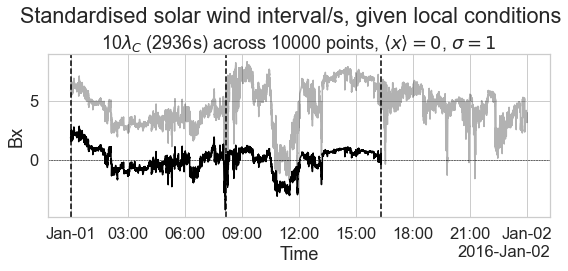

In [145]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind interval/s, given local conditions" , y= 1.1)
# Add subtitle
plt.title(f"{tc_n}$\lambda_C$ ({int(tc)}s) across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel(f"{interval.name}")

output_file_path = raw_file_list[file_index].replace("data/raw", "plots/temp").replace(".cdf", "_ints.png")
plt.savefig(output_file_path, bbox_inches='tight')

In [146]:
files_metadata = pd.DataFrame({
    "file_index": file_index,
    "file_start": df.index[0],
    "file_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
files_metadata

,file_index,file_start,file_end,tc,cadence
0,0,2016-01-01,2016-01-01 23:59:59,2936.371,2.936371


In [147]:
ints_metadata = pd.DataFrame({
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_metadata.reset_index(inplace=True)
ints_metadata.rename(columns={"index": "int_index"}, inplace=True)
ints_metadata.insert(0, "file_index", file_index)
ints_metadata

,file_index,int_index,int_start,int_end
0,0,0,2016-01-01 00:00:00,2016-01-01 08:09:17.064
1,0,1,2016-01-01 08:09:20,2016-01-01 16:18:37.064


## 2c. Analyse intervals (get true SF and slope)

In [148]:
lags = np.arange(1, 0.1 * len(ints[0]))

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))

powers = [2]
pwrl_range = [10,100]

In [149]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, pwrl_range)
    good_output.insert(0, "int_index", i)
    good_output.insert(1, "file_index", file_index)
    sfs = pd.concat([sfs, good_output])
    ints_metadata.loc[ints_metadata["int_index"]==i, "slope"] = slope

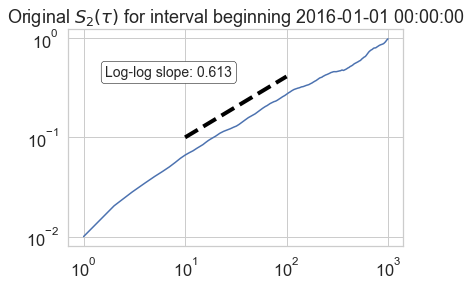

In [150]:
check_int = 0
slope = ints_metadata.loc[ints_metadata["int_index"]==check_int, "slope"].values[0]
timestamp = ints_metadata.loc[ints_metadata["int_index"]==check_int, "int_start"][0]

from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==check_int, "lag"], sfs.loc[sfs["int_index"]==check_int, "sf_2"])
pltpwrl(10,0.1, 10, 100, slope, lw=4, ls="--", color="black")
# Annotate with slope
plt.annotate(
    f"Log-log slope: {slope:.3f}",
    xy=(0.3, 0.8),
    xycoords="axes fraction",
    ha="center",
    va="center",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
    fontsize=14
)
plt.semilogx()
plt.semilogy()
plt.title(f"Original $S_2(\\tau)$ for interval beginning {timestamp}")

output_file_path = raw_file_list[file_index].replace("data/raw", "plots/temp").replace(".cdf", "_sf_example.png")
plt.savefig(output_file_path.replace("_ints.png", "_sf_example.png"), bbox_inches='tight')

## 2d. Duplicate, gap, interpolate, re-analyse intervals
Gap in $x$ different ways, then calculate SF and corresponding slope for gappy (naive) and interpolated (lint) versions of each of these duplicate intervals.

In [151]:
minimum_missing_chunks = 0.7
np.random.seed(123) # For reproducibility

In [152]:
index_list = []
version_list = []
handling_list = []
missing_list = []
missing_chunks_list = []
slopes_list = []

sfs_gapped = pd.DataFrame()
ints_gapped = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_chunks, bad_input_ind_chunks, prop_removed_chunks = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        # Add the uniform gaps on top of chunks gaps 
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_chunks, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False)
        bad_output["file_index"] = file_index
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["gap_handling"] = "naive"
        sfs_gapped = pd.concat([sfs_gapped, bad_output])

        for handling in ["naive", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            missing_chunks_list.append(prop_removed_chunks*100)
            
            handling_list.append(handling)

            if handling == "naive":
                slopes_list.append(slope)
                # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df.reset_index(inplace=True)
                bad_input_df["file_index"] = file_index 
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                bad_input_df["gap_handling"] = handling
                ints_gapped = pd.concat([ints_gapped, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df.reset_index(inplace=True) # Make time a column, not an index
                interp_input_df["file_index"] = file_index
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["gap_handling"] = handling
                ints_gapped = pd.concat([ints_gapped, interp_input_df])

                interp_output["file_index"] = file_index
                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["gap_handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["n"] = bad_output["n"]
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_gapped = pd.concat([sfs_gapped, interp_output])

In [153]:
ints_gapped_metadata = pd.DataFrame({
    "file_index": file_index,
    "int_index": index_list, 
    "version": version_list, 
    "missing_percent_overall": missing_list, 
    "missing_percent_chunks": missing_chunks_list, 
    "gap_handling": handling_list})

## Export dataframes as pickle file

In [154]:
# Export the dataframes in one big pickle file
output_file_path = raw_file_list[file_index].replace("raw", "processed").replace(".cdf", ".pkl")

with open(output_file_path, "wb") as f:
    pickle.dump(
        {
            "files_metadata": files_metadata,
            "ints_metadata": ints_metadata,
            "ints": ints,
            "ints_gapped_metadata": ints_gapped_metadata,
            "ints_gapped": ints_gapped,
            "sfs": sfs,
            "sfs_gapped": sfs_gapped,
        },
        f,
    )

# 3. FOR ALL INTERVALS IN TRAINING SET: calculate correction
for statistical analysis of errors.

From here on, we need to be careful to select each interval AS A COMBINATION OF KEYS: file_index and int_index

## Train-test split

In [155]:
# Randomly select 20% of the pickle files in data/processed/psp, and move them into a subfolder called 'test'
# The remaining 80% will be moved into a subfolder called 'train'

# Get all the pickle files in data/psp/processed
pickle_files = sorted(glob.glob("data/processed/psp/psp_*.pkl"))

train_frac = 0.8

# Randomly shuffle the list of pickle files
np.random.seed(123) # For reproducibility
np.random.shuffle(pickle_files)

# Split the list of pickle files into a training set and a test set
n_files = len(pickle_files)
n_train = int(train_frac * n_files)

train_files = pickle_files[:n_train]
test_files = pickle_files[n_train:]

# Create the 'train' and 'test' subfolders if they don't already exist
os.makedirs("data/processed/psp/train", exist_ok=True)

# Move the training files into the 'train' subfolder
for file in train_files:
    shutil.move(file, file.replace("processed/psp", "processed/psp/train"))

# Create the 'test' subfolder if it doesn't already exist
os.makedirs("data/processed/psp/test", exist_ok=True)

# Move the test files into the 'test' subfolder
for file in test_files:
    shutil.move(file, file.replace("processed/psp", "processed/psp/test"))

# Check the number of files in each subfolder
train_files = sorted(glob.glob("data/processed/psp/train/psp_*.pkl"))
test_files = sorted(glob.glob("data/processed/psp/test/psp_*.pkl"))

print(f"Number of files in PSP 'train' subfolder: {len(train_files)}")
print(f"Number of files in PSP 'test' subfolder: {len(test_files)}")

Number of files in PSP 'train' subfolder: 2
Number of files in PSP 'test' subfolder: 1


In [26]:
spacecraft = "psp"

files_metadata, ints_metadata, ints, ints_gapped_metadata, ints_gapped, sfs, sfs_gapped = sf.load_and_concatenate_dataframes(
    [sorted(glob.glob("data/processed/psp/train/psp_*.pkl"))][0])


## Calculate lag-scale errors (sf_2_pe)
Join original and copies dataframes and do column operation

In [27]:
ints_gapped_metadata = pd.merge(ints_metadata, ints_gapped_metadata, how="inner", on=["file_index", "int_index"], suffixes=("_orig", ""))

In [28]:
sfs_gapped = pd.merge(sfs, sfs_gapped, how="inner", on=["file_index", "int_index", "lag"], suffixes=("_orig", ""))
sfs_gapped["sf_2_pe"] = (sfs_gapped["sf_2"] - sfs_gapped["sf_2_orig"]) / sfs_gapped["sf_2_orig"] * 100

## Compute and export heatmaps

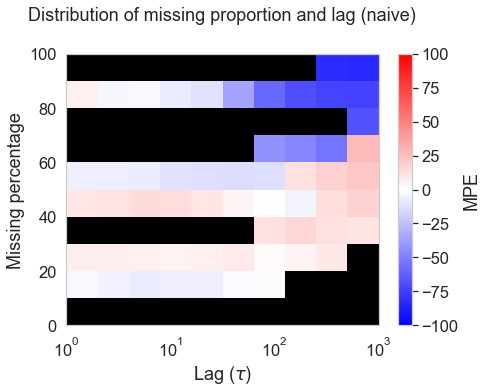

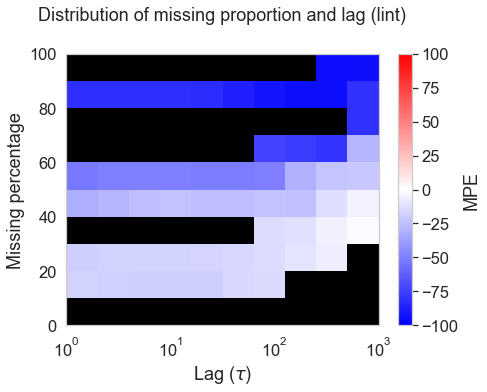

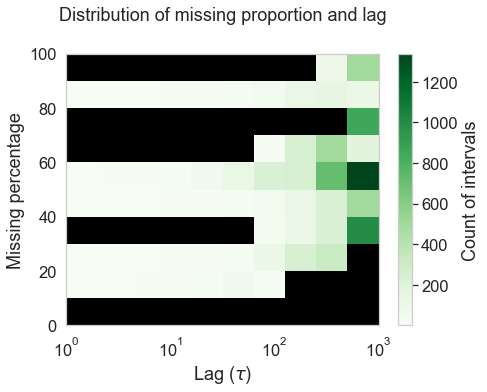

In [29]:
n_bins = 10

for gap_handling in ["naive", "lint"]:
    heatmap_bin_vals_2d, heatmap_bin_counts_2d, heatmap_bin_edges_2d, lookup_table_2d = sf.create_heatmap_lookup(
        sfs_gapped[sfs_gapped["gap_handling"]==gap_handling], "missing_percent", n_bins, log=True
    )

    # Mean percentage error per bin
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.pcolormesh(
        heatmap_bin_edges_2d[0],
        heatmap_bin_edges_2d[1],
        heatmap_bin_vals_2d.T,
        cmap="bwr",
    )
    plt.colorbar(label="MPE")
    plt.clim(-100, 100)
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Missing percentage")
    plt.title(f"Distribution of missing proportion and lag ({gap_handling})", y=1.1)
    ax.set_facecolor("black")
    ax.set_xscale("log")
    ax.grid(False)

    plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_2d_{gap_handling}.png", bbox_inches='tight')

# Count of pairs per bin (same for both)
fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d[0],
    heatmap_bin_edges_2d[1],
    heatmap_bin_counts_2d.T,
    cmap="Greens",
)
# Remove gridlines
plt.colorbar(label="Count of intervals")
plt.xlabel("Lag ($\\tau$)")
plt.ylabel("Missing percentage")
plt.title(f"Distribution of missing proportion and lag", y=1.1)
ax.set_facecolor("black")
ax.set_xscale("log")
ax.grid(False)
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_2d_counts.png", bbox_inches='tight')

Potential future sample size analysis

In [81]:
# Get proportion of nans in the flattened array
#print(np.isnan(heatmap_bin_counts_2d.flatten()).sum() / len(heatmap_bin_counts_2d.flatten())*100, "% of bins in the grid have no corresponding data")

# Summarise this array in terms of proportion of missing values, minimum value, and median value
#print(np.nanmedian(heatmap_bin_counts_2d), "is the median count of each bin")

# For each heatmap, print these stats.
# Also, for the correction part, note when there is no corresponding bin.

In [30]:
# Because the LINT version was calculated most recently, this is what we have here
lookup_table_2d.head()

,lag,missing_percent,n,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,15.0,2,-17.580351,6.827028,-24.407379,-10.753323,1.213303,1.120490,1.322880
1,1.487531,25.0,1,-18.752573,0.000000,-18.752573,-18.752573,1.230808,1.230808,1.230808
2,1.487531,45.0,1,-31.880500,0.000000,-31.880500,-31.880500,1.468008,1.468008,1.468008
3,1.487531,55.0,4,-52.772679,20.662188,-80.063845,-30.026540,2.117418,1.429113,5.016012
4,1.487531,85.0,1,-81.725557,0.000000,-81.725557,-81.725557,5.472123,5.472123,5.472123


In [31]:
gap_handling = "lint"

heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        sfs_gapped[sfs_gapped["gap_handling"]==gap_handling], "missing_percent", n_bins, True
    )
)

# Plotting 3D heatmaps

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Missing proportion")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag ($\\tau$)")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_3d_{gap_handling}_power.png", bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlabel("Missing prop")
    ax[i].set_ylabel("Power")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_3d_{gap_handling}_lag.png", bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Missing prop bin {i+1}/{n_bins}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    ax[i].set_xlabel("Lag ($\\tau$)")
    ax[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_3d_{gap_handling}_missing.png", bbox_inches='tight')
plt.close()

In [84]:
lookup_table_3d.head()

,lag,missing_percent,sf_2,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,15.0,0.014976,-17.580351,6.827028,-24.407379,-10.753323,1.213303,1.120490,1.322880
1,1.487531,55.0,0.014976,-32.887879,2.861339,-35.749219,-30.026540,1.490044,1.429113,1.556401
2,2.977669,15.0,0.029882,-20.778464,7.659406,-26.508553,-9.952622,1.262283,1.110527,1.360703
3,2.977669,15.0,0.059622,-10.032690,0.000000,-10.032690,-10.032690,1.111515,1.111515,1.111515
4,2.977669,25.0,0.014976,-17.888923,0.000000,-17.888923,-17.888923,1.217862,1.217862,1.217862


In [32]:
# Export the lookup tables
print("Exporting lookup tables to CSV")
lookup_table_2d.to_csv(f"data/processed/lookup_table_2d_{n_bins}bins.csv")
lookup_table_3d.to_csv(f"data/processed/lookup_table_3d_{n_bins}bins.csv")

# Export heatmap as a pickle for final case study correction figure
with open(f"data/processed/heatmap_2d_{n_bins}bins.pkl", "wb") as f:
    pickle.dump(
        {
            "heatmap_bin_vals_2d": heatmap_bin_vals_2d,
            "heatmap_bin_edges_2d": heatmap_bin_edges_2d,
        },
        f,
    )

Exporting lookup tables to CSV


## Other plots of error trends

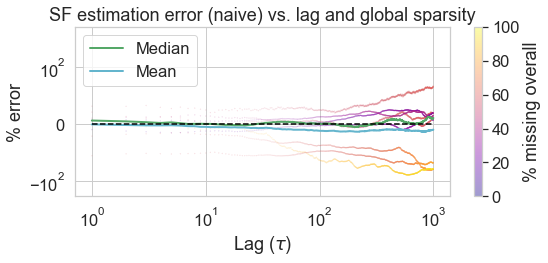

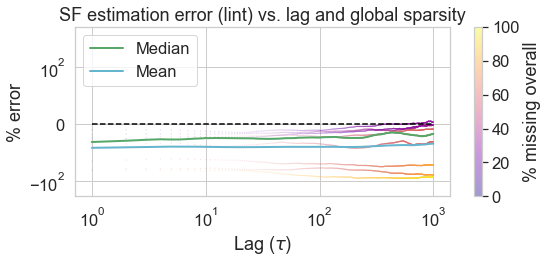

In [179]:
for gap_handling in sfs_gapped.gap_handling.unique():
    sf.plot_error_trend_line(sfs_gapped[sfs_gapped["gap_handling"]==gap_handling], estimator="sf_2", title = f"SF estimation error ({gap_handling}) vs. lag and global sparsity", y_axis_log=True)
    plt.savefig(f"plots/temp/train_{spacecraft}_error_trend_{gap_handling}.png", bbox_inches='tight')

# 4. FOR EACH INTERVAL IN TEST SET: apply correction

In [2]:
#spacecraft = "psp"
n_bins = 10
times_to_gap = 3
pwrl_range = [10,100]
spacecraft = "wind"

In [26]:
# Importing processed time series and structure functions
processed_files = [sorted(glob.glob("data/processed/wind/wi_*.pkl"))[0]]
# [sorted(glob.glob("data/processed/psp/test/psp_*.pkl"))[0]])

files_metadata, ints_metadata, ints, ints_gapped_metadata, ints_gapped, sfs, sfs_gapped = sf.load_and_concatenate_dataframes(
    processed_files
    )


In [5]:
# Importing lookup table
lookup_table_2d = pd.read_csv(f"data/processed/lookup_table_2d_{n_bins}bins.csv", index_col=0)
lookup_table_3d = pd.read_csv(f"data/processed/lookup_table_3d_{n_bins}bins.csv", index_col=0)

# Also get the 2d heatmap for final case study correction figure, by undoing the above operation

with open(f"data/processed/heatmap_2d_{n_bins}bins.pkl", "rb") as f:
    data = pickle.load(f)

heatmap_bin_vals_2d = data["heatmap_bin_vals_2d"]
heatmap_bin_edges_2d = data["heatmap_bin_edges_2d"]


In [6]:
# Apply 2D and 3D scaling to test set, report avg errors
print(f"Correcting interpolated test set intervals using 2D error heatmap with {n_bins} bins")
sfs_gapped_corrected = sf.compute_scaling(
    sfs_gapped[sfs_gapped["gap_handling"]=="lint"], "missing_percent", lookup_table_2d
)

Correcting interpolated test set intervals using 2D error heatmap with 10 bins


In [7]:
print(f"Correcting interpolated test set intervals using 3D error heatmap with {n_bins} bins")
sfs_gapped_corrected = sf.compute_scaling_3d(
    sfs_gapped_corrected[sfs_gapped_corrected["gap_handling"]=="lint"], "missing_percent", lookup_table_3d
)

Correcting interpolated test set intervals using 3D error heatmap with 10 bins


In [8]:
sfs_gapped_corrected.head()

,lag,n,missing_percent,sf_2,sf_2_se,file_index,int_index,version,gap_handling,scaling,...,sf_2_upper_corrected_2d_smoothed,sf_2_corrected_3d,sf_2_lower_corrected_3d,sf_2_upper_corrected_3d,scaling_3d_smoothed,scaling_lower_3d_smoothed,scaling_upper_3d_smoothed,sf_2_corrected_3d_smoothed,sf_2_lower_corrected_3d_smoothed,sf_2_upper_corrected_3d_smoothed
999,1.0,4672,53.275328,0.003686,0.000531,0,0,0,lint,1.490044,...,0.018490,0.005493,0.003851,0.009575,1.490044,1.044654,2.597489,0.005493,0.003851,0.009575
1000,2.0,4662,53.370674,0.008505,0.001173,0,0,0,lint,1.490044,...,0.042659,0.012672,0.008884,0.022091,1.490044,1.044654,2.597489,0.012672,0.008884,0.022091
1001,3.0,4669,53.295989,0.012429,0.001660,0,0,0,lint,2.692427,...,0.061118,0.033463,0.028830,0.039869,1.890838,1.469667,2.800951,0.023500,0.018266,0.034812
1002,4.0,4660,53.381353,0.015749,0.002217,0,0,0,lint,2.692427,...,0.076670,0.042402,0.036532,0.050520,2.091236,1.682173,2.902682,0.032934,0.026492,0.045713
1003,5.0,4668,53.296648,0.018849,0.002171,0,0,0,lint,4.657097,...,0.091112,0.087783,0.082394,0.093925,2.604408,2.219982,3.318743,0.049091,0.041845,0.062556


In [9]:
correction_wide =  sfs_gapped_corrected[["file_index", "int_index", "version", "lag", "missing_percent", "sf_2_corrected_2d", "sf_2_corrected_3d"]]
correction_long = pd.wide_to_long(correction_wide, ["sf_2"], i=["file_index", "int_index", "version", "lag", "missing_percent"], j="gap_handling", sep="_", suffix=r"\w+")
correction_bounds_wide =  sfs_gapped_corrected[["file_index", "int_index", "version", "lag", "missing_percent", "sf_2_lower_corrected_2d", "sf_2_lower_corrected_3d", "sf_2_upper_corrected_2d", "sf_2_upper_corrected_3d"]]
correction_bounds_long = pd.wide_to_long(correction_bounds_wide, ["sf_2_lower", "sf_2_upper"], i=["file_index", "int_index", "version", "lag", "missing_percent"], j="gap_handling", sep="_", suffix=r"\w+")

corrections_long = pd.merge(correction_long, correction_bounds_long, how="inner", on=["file_index", "int_index", "version", "lag", "missing_percent", "gap_handling"]).reset_index()

In [10]:
# Adding the corrections, now as a form of "gap_handling", back to the gapped SF dataframe
sfs_gapped_corrected = pd.concat([sfs_gapped, corrections_long])

# Merging the original SFs with the corrected ones to then calculate errors
sfs_gapped_corrected = pd.merge(sfs, sfs_gapped_corrected, how="inner", on=["file_index", "int_index", "lag"], suffixes=("_orig", ""))

#### Calculate lag-scale errors (sf_2_pe)
This is the first time we calculate these errors, for this specific dataset (they were calculated before for the training set)

Previously this didn't work as we had two sf_2_orig columns as the result of merging a dataframe that had already previously been merged. However, this initial merge is no longer taking place, as it is only now that we are calculating any errors *of any sort, including lag-specific ones*, for this particular dataset.

In [11]:
sfs_gapped_corrected["sf_2_pe"] = (sfs_gapped_corrected["sf_2"] - sfs_gapped_corrected["sf_2_orig"]) / sfs_gapped_corrected["sf_2_orig"] * 100

### Calculate interval-scale errors
This is the first time we do this. We do not need these values for the training set, because we only use that for calculating the correction factor, which uses lag-scale errors..

In [12]:
# Adding rows as placeholders for when we correct with 2D and 3D heatmaps and want to calculate errors

dup_df = ints_gapped_metadata.replace(["naive","lint"], ["corrected_2d", "corrected_3d"])
ints_gapped_metadata = pd.concat([ints_gapped_metadata, dup_df])

In [13]:
for i in files_metadata.file_index.unique():
    for j in range(len(ints_metadata["file_index"]==i)):
        for k in range(times_to_gap):
            for gap_handling in sfs_gapped_corrected.gap_handling.unique():
            # Calculate MAPE for 2D and 3D corrected SFs
                
                ints_gapped_metadata.loc[
                    (ints_gapped_metadata["file_index"]==i) &
                    (ints_gapped_metadata["int_index"]==j) & 
                    (ints_gapped_metadata["version"]==k) & 
                    (ints_gapped_metadata["gap_handling"]==gap_handling), 
                    "mape"] = np.mean(
                    np.abs(
                        sfs_gapped_corrected.loc[
                            (sfs_gapped_corrected["file_index"]==i) &
                            (sfs_gapped_corrected["int_index"]==j) & 
                            (sfs_gapped_corrected["version"]==k) & 
                            (sfs_gapped_corrected["gap_handling"]==gap_handling), 
                            "sf_2_pe"]))

                ints_gapped_metadata.loc[
                    (ints_gapped_metadata["file_index"]==i) &
                    (ints_gapped_metadata["int_index"]==j) & 
                    (ints_gapped_metadata["version"]==k) & 
                    (ints_gapped_metadata["gap_handling"]==gap_handling), 
                    "mpe"] = np.mean(
                        sfs_gapped_corrected.loc[
                            (sfs_gapped_corrected["file_index"]==i) &
                            (sfs_gapped_corrected["int_index"]==j) & 
                            (sfs_gapped_corrected["version"]==k) & 
                            (sfs_gapped_corrected["gap_handling"]==gap_handling), 
                            "sf_2_pe"])
                
                # Calculate power-law slope for 2D and 3D corrected SFs
                current_int = sfs_gapped_corrected.loc[
                    (sfs_gapped_corrected["file_index"]==i) &
                    (sfs_gapped_corrected["int_index"]==j) & 
                    (sfs_gapped_corrected["version"]==k) & 
                    (sfs_gapped_corrected["gap_handling"]==gap_handling)]

                # Fit a line to the log-log plot of the structure function over the given range

                slope = np.polyfit(
                    np.log(current_int.loc[(current_int["lag"] >= pwrl_range[0]) & (current_int["lag"] <= pwrl_range[1]), "lag"]),
                    np.log(current_int.loc[(current_int["lag"] >= pwrl_range[0]) & (current_int["lag"] <= pwrl_range[1]), "sf_2"]),
                    1,
                )[0]

                ints_gapped_metadata.loc[
                    (ints_gapped_metadata["file_index"]==i) &
                    (ints_gapped_metadata["int_index"]==j) & 
                    (ints_gapped_metadata["version"]==k) & 
                    (ints_gapped_metadata["gap_handling"]==gap_handling), 
                    "slope"] = slope

In [14]:
slope = np.polyfit(
    np.log(current_int.loc[(current_int["lag"] >= pwrl_range[0]) & (current_int["lag"] <= pwrl_range[1]), "lag"]),
    np.log(current_int.loc[(current_int["lag"] >= pwrl_range[0]) & (current_int["lag"] <= pwrl_range[1]), "sf_2"]),
    1,
)[0]

In [15]:
# Calculate slope errors
ints_gapped_metadata = pd.merge(ints_gapped_metadata, ints_metadata.drop(["int_start", "int_end"], axis=1), how="inner", on=["file_index", "int_index"], suffixes=("", "_orig"))

In [16]:
# maybe come back to this method of getting true slopes, could be fun

# # Create a dictionary from df2 with composite keys
# value2_dict = df2.set_index(['key1', 'key2'])['value2'].to_dict()

# # Create a composite key in df1 and map the values
# df1['composite_key'] = list(zip(df1['key1'], df1['key2']))
# df1['value2'] = df1['composite_key'].map(value2_dict)

In [17]:
ints_gapped_metadata["slope_pe"] = (ints_gapped_metadata["slope"] - ints_gapped_metadata["slope_orig"]) / ints_gapped_metadata["slope_orig"] * 100
ints_gapped_metadata["slope_ape"] = np.abs(ints_gapped_metadata["slope_pe"])

In [ ]:
# Export the final dataframes, ints_gapped_metadata and sfs_gapped_corrected, in a pickle file
output_file_path = processed_files[file_index].replace("raw", "processed").replace(".cdf", ".pkl")

In [ ]:


with open(output_file_path, "wb") as f:
    pickle.dump(
        {
            "files_metadata": files_metadata,
            "ints_metadata": ints_metadata,
            "ints": ints,
            "ints_gapped_metadata": ints_gapped_metadata,
            "ints_gapped": ints_gapped,
            "sfs": sfs,
            "sfs_gapped": sfs_gapped,
            "sfs_gapped_corrected": sfs_gapped_corrected,
        },
        f,
    )

# 5. FOR ALL INTERVALS IN TEST SET: get overall test set results

### Box plots

In [18]:
ints_gapped_metadata.groupby("gap_handling")[["missing_percent_overall", "slope", "slope_pe", "mpe", "mape"]].agg(["mean", "median", "std", "min", "max"])

missing_percent_overall                                  \
                                mean median        std    min    max   
gap_handling                                                           
corrected_2d               43.218333  41.56  24.046716  14.97  82.08   
corrected_3d               43.218333  41.56  24.046716  14.97  82.08   
lint                       43.218333  41.56  24.046716  14.97  82.08   
naive                      43.218333  41.56  24.046716  14.97  82.08   

                 slope                                          ...  \
                  mean    median       std       min       max  ...   
gap_handling                                                    ...   
corrected_2d  0.724913  0.708325  0.112472  0.585993  0.921677  ...   
corrected_3d  0.502034  0.697680  0.494237 -0.493464  0.781558  ...   
lint          0.661380  0.693135  0.111155  0.457266  0.762293  ...   
naive         0.658637  0.687905  0.095262  0.482505  0.744331  ...   

                    mpe                                               \
                   mean     median        std        min         max   
gap_handling                                                           
corrected_2d  43.361877   2.801313  85.994286 -19.770751  199.061199   
corrected_3d  16.806751   4.292168  52.148833 -28.554569  116.211228   
lint         -34.951267 -33.709461  30.121655 -87.109835   -5.448938   
naive          3.085830  -4.636358  35.966287 -26.709891   73.605637   

                   mape                                              
                   mean     median        std       min         max  
gap_handling                                                         
corrected_2d  56.906691  20.979800  76.417213  5.161020  199.061199  
corrected_3d  45.191971  35.474644  44.319045  6.445678  123.795936  
lint          34.951267  33.709461  30.121655  5.448938   87.109835  
naive         27.750641  22.671960  24.216651  5.886311   73.605637  

[4 rows x 25 columns]

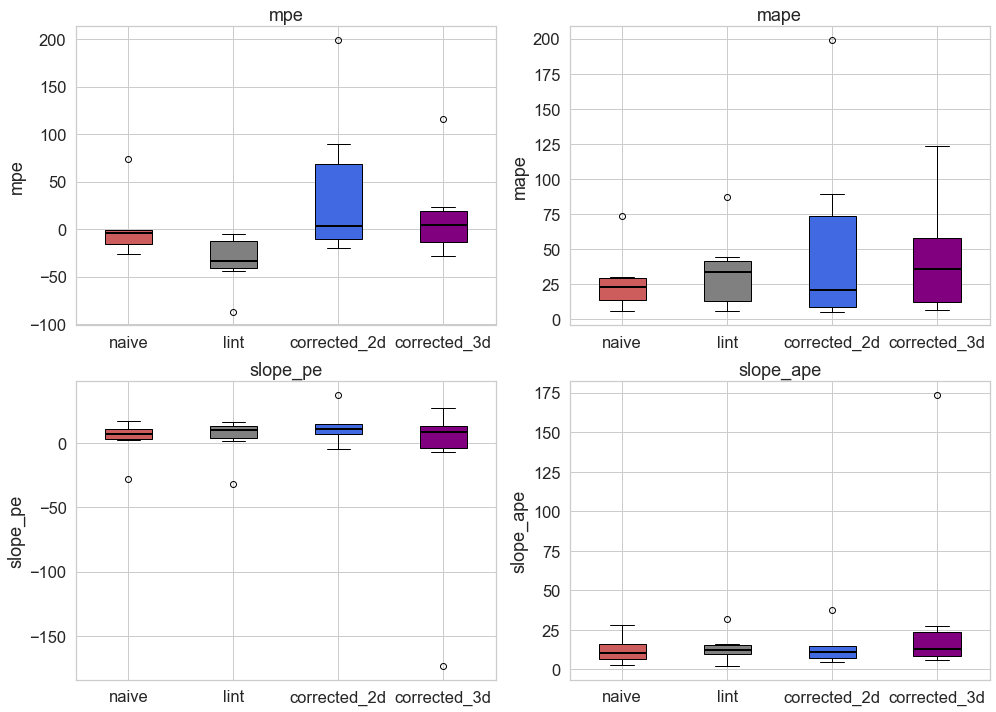

In [19]:
import matplotlib.pyplot as plt

# Assuming ints_gapped_metadata is your DataFrame
# Define the list of columns to plot
columns = ["mpe", "mape", "slope_pe", "slope_ape"]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

custom_order = ["naive", "lint", "corrected_2d", "corrected_3d"]
colors = ['indianred', 'grey', 'royalblue', 'purple']

# Create boxplots for each column
for col, ax in zip(columns, axes):
    data_to_plot = [ints_gapped_metadata[ints_gapped_metadata['gap_handling'] == method][col] for method in custom_order]
    box = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Set colors for the boxes
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set colors for the median lines
    median_color = 'black'
    for median in box['medians']:
        median.set_color(median_color)
        median.set_linewidth(2)  # optional: set line width to make it more prominent

    ax.set_title(f'{col}')
    ax.set_ylabel(f'{col}')
    ax.set_xticklabels(custom_order)

# Adjust layout
plt.tight_layout()
plt.suptitle('')  # Remove the default title to avoid overlap
plt.savefig(f"plots/temp/test_{spacecraft}_boxplots.png", bbox_inches='tight')

### Regression lines

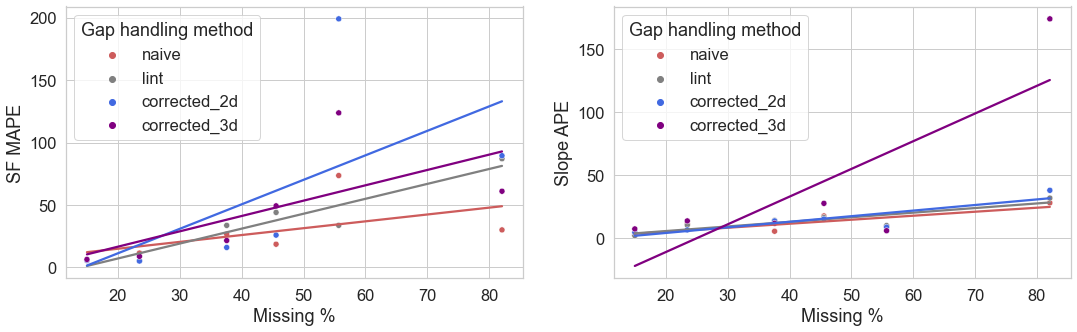

In [20]:
# Make scatterplot of mape vs. missing_percent, coloured by gap handling
palette = dict(zip(custom_order, colors))

# Plotting the MAPE vs. missing percentage
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(data=ints_gapped_metadata, x="missing_percent_overall", y="mape", hue="gap_handling", palette=palette, ax = ax[0])
ax[0].legend(title="Gap handling method")

# Add regression lines for each group
unique_gap_handling = ints_gapped_metadata['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_gapped_metadata[ints_gapped_metadata['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="mape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[0])

sns.scatterplot(data=ints_gapped_metadata, x="missing_percent_overall", y="slope_ape", hue="gap_handling", palette=palette, ax = ax[1])
ax[1].legend(title="Gap handling method")

# Add regression lines for each group

unique_gap_handling = ints_gapped_metadata['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_gapped_metadata[ints_gapped_metadata['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="slope_ape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[1])
    #r.legend.set_title("Gap handling method")
    
ax[0].set_xlabel("Missing %")
ax[0].set_ylabel("SF MAPE")
ax[1].set_xlabel("Missing %")
ax[1].set_ylabel("Slope APE")

plt.savefig(f"plots/temp/test_{spacecraft}_scatterplots.png", bbox_inches='tight')

### Error trendlines

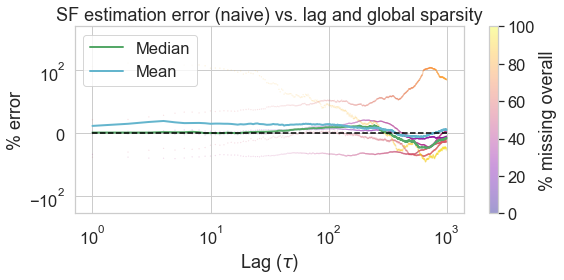

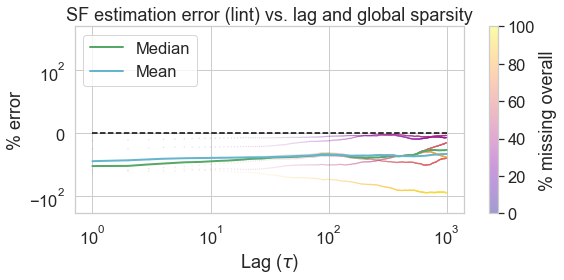

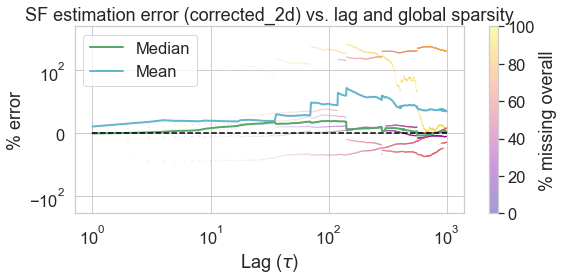

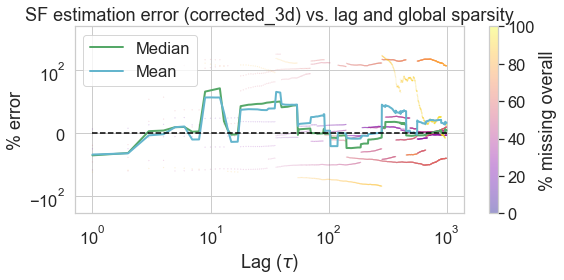

In [21]:
for gap_handling in sfs_gapped_corrected.gap_handling.unique():
    sf.plot_error_trend_line(sfs_gapped_corrected[sfs_gapped_corrected["gap_handling"]==gap_handling], estimator="sf_2", title = f"SF estimation error ({gap_handling}) vs. lag and global sparsity", y_axis_log=True)
    plt.savefig(f"plots/temp/test_{spacecraft}_error_trend_{gap_handling}.png", bbox_inches='tight')

### 5d. Pre-correction case studies

   missing_percent_overall  gap_handling       mape   slope_pe
0                    45.55         naive  18.634029  17.495475
1                    45.55          lint  44.088835  16.209560
6                    45.55  corrected_2d  25.924826  14.951715
7                    45.55  corrected_3d  49.343359  27.445474
   missing_percent_overall  gap_handling        mape  slope_pe
2                    55.68         naive   73.605637  9.435608
3                    55.68          lint   33.720480  9.843917
8                    55.68  corrected_2d  199.061199  8.586072
9                    55.68  corrected_3d  123.795936  5.745945


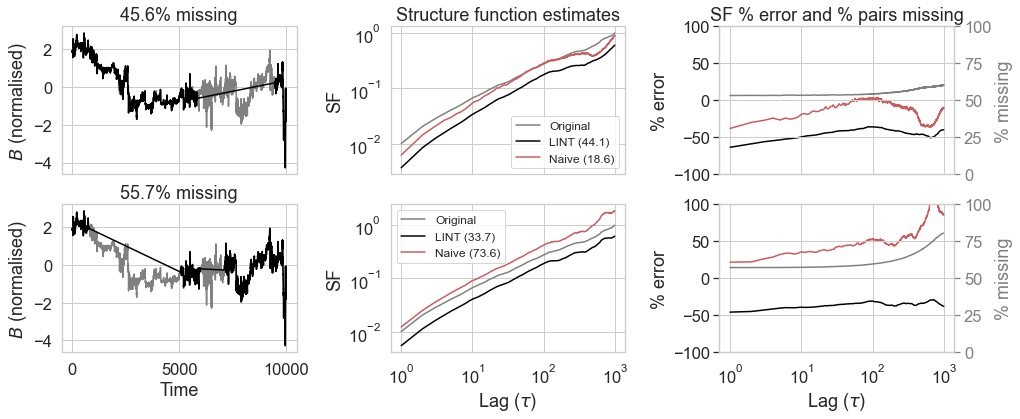

In [22]:
# Below variables say to plot two versions of the first interval

file_index = ints_gapped_metadata["file_index"].unique()[0]
int_index=0
num_version_to_plot = 2

fig, ax = plt.subplots(num_version_to_plot, 3, figsize=(16, num_version_to_plot*3))

for version in range(num_version_to_plot):
    ax[version, 0].plot(ints[int_index][0].values, c = "grey")
    ax[version, 0].plot(
        ints_gapped.loc[
            (ints_gapped["file_index"]==file_index) &
            (ints_gapped["int_index"]==int_index) & 
                        (ints_gapped["version"]==version) & 
                        (ints_gapped["gap_handling"]=="lint"), "Bx"].values, c="black")

    # Put missing_percent_overall in the title
    ax[version, 0].set_title(f"{ints_gapped_metadata.loc[(ints_gapped_metadata['file_index']==file_index) & (ints_gapped_metadata['int_index']==int_index) & (ints_gapped_metadata['version']==version) & (ints_gapped_metadata['gap_handling']=='lint'), 'missing_percent_overall'].values[0]:.1f}% missing")

    # Plot the SF
    ax[version, 1].plot(
        sfs.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs["int_index"]==int_index), "lag"],
        sfs.loc[(sfs["int_index"]==int_index), "sf_2"], c="grey", label = "Original")

    ax[version, 1].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "sf_2"], c="black", 
                        label="LINT ({:.1f})".format(ints_gapped_metadata.loc[(ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="lint"), "mape"].values[0]),)
    ax[version, 1].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "sf_2"], c="indianred",
                        label="Naive ({:.1f})".format(ints_gapped_metadata.loc[(ints_gapped_metadata["int_index"]==int_index) &
                                        (ints_gapped_metadata["version"]==version) &
                                        (ints_gapped_metadata["gap_handling"]=="naive"), "mape"].values[0]),)
    
    # Plot the sf_2_pe
    ax[version, 2].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "sf_2_pe"], c="black")
    ax[version, 2].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"], 
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "sf_2_pe"], c="indianred")
    
    # plot sample size n on right axis
    ax2 = ax[version, 2].twinx()
    ax2.plot(
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) & 
                       (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "missing_percent"], c="grey")

    # Label the axes
    ax[1, 0].set_xlabel("Time")
    ax[version, 0].set_ylabel("$B$ (normalised)")
    ax[1, 1].set_xlabel("Lag ($\\tau$)")
    ax[version, 1].set_ylabel("SF")
    ax[1, 2].set_xlabel("Lag ($\\tau$)")
    ax[version, 2].set_ylabel("% error")
    ax2.set_ylabel("% missing", color="grey")
    ax2.tick_params(axis="y", colors="grey")
    ax2.set_ylim(0,100)

    #ax[version, 2].axhline(0, c="black", linestyle="--")
    ax[version, 2].set_ylim(-100, 100)

    ax[version, 1].set_xscale("log")
    ax[version, 1].set_yscale("log")
    ax[version, 2].set_xscale("log")
    ax[version, 1].legend(fontsize=12)
    [ax[0, i].set_xticklabels([]) for i in range(3)]

    print(ints_gapped_metadata.loc[(ints_gapped_metadata["int_index"]==int_index) & (ints_gapped_metadata["version"]==version)][["missing_percent_overall", "gap_handling", "mape", "slope_pe"]])


# Add titles
ax[0, 1].set_title("Structure function estimates")
ax[0, 2].set_title("SF % error and % pairs missing")
plt.subplots_adjust(wspace=0.4)

plt.savefig(f"plots/temp/test_{spacecraft}_case_study_gapping_{file_index}_{int_index}.png", bbox_inches='tight')

### 5e. Corrected case studies

In [23]:
# Annotate each heatmap trace with info
def annotate_curve(ax, x, y, text, offset_scaling=(0.3, 0.1)):
    # Find the index of y value closest to the median value
    idx = np.argmin(np.abs(y - np.percentile(y, 20)))

    # Coordinates of the point of maximum y value
    x_max = x.iloc[idx]
    y_max = y.iloc[idx]

    # Convert offset from axes fraction to data coordinates
    x_text = 10 ** (offset_scaling[0] * np.log10(x_max))  # Log-axis
    y_text = y_max + offset_scaling[1] * (ax.get_ylim()[1] - ax.get_ylim()[0])

    # Annotate with the text, adjusting the position with xytext_offset
    ax.annotate(
        text,
        xy=(x_max, y_max - 1),
        xytext=(x_text, y_text),
        # xycoords="axes fraction",
        # textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round", alpha=0.7),
    )

   missing_percent_overall  gap_handling       mape   slope_pe
0                    45.55         naive  18.634029  17.495475
1                    45.55          lint  44.088835  16.209560
6                    45.55  corrected_2d  25.924826  14.951715
7                    45.55  corrected_3d  49.343359  27.445474
   missing_percent_overall  gap_handling        mape  slope_pe
2                    55.68         naive   73.605637  9.435608
3                    55.68          lint   33.720480  9.843917
8                    55.68  corrected_2d  199.061199  8.586072
9                    55.68  corrected_3d  123.795936  5.745945


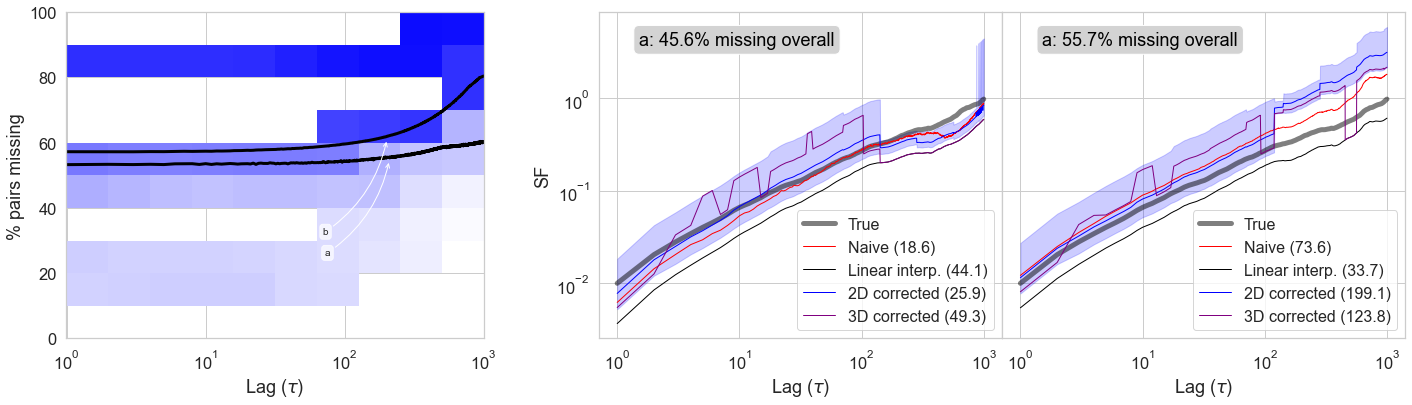

In [24]:
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec layout with specified width ratios and horizontal space
gs1 = GridSpec(1, 1, left=0.06, right=0.35)
gs2 = GridSpec(1, 2, left=0.43, right=0.99, wspace=0)

# Create subplots
ax0 = fig.add_subplot(gs1[0, 0])
ax1 = fig.add_subplot(gs2[0, 0])

for version in range(2):

    if version == 0:
        ax = ax1
        ax.set_ylabel("SF")
    else:
        ax = fig.add_subplot(gs2[0, version], sharey=ax1)
        plt.setp(ax.get_yticklabels(), visible=False)
        
    ax.plot(
        sfs[sfs["int_index"]==int_index]["lag"],
        sfs[sfs["int_index"]==int_index]["sf_2"],
        color="black",
        label="True",
        lw=5,
        alpha=0.5,
    )
    ax.plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"],
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="naive"), "sf_2"],
        color="red",
        lw=1,
        label="Naive ({:.1f})".format(ints_gapped_metadata.loc[
            (ints_gapped_metadata["file_index"]==file_index) &
            (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="naive"), "mape"].values[0]),
    )
    ax.plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"],
        sfs_gapped_corrected.loc[
                        (sfs_gapped_corrected["file_index"]==file_index) &            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "sf_2"],
        color="black",
        lw=1,
        label="Linear interp. ({:.1f})".format(ints_gapped_metadata.loc[
                        (ints_gapped_metadata["file_index"]==file_index) &            
            (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="lint"), "mape"].values[0]),
    )
    ax.plot(
        sfs_gapped_corrected.loc[
            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "lag"],
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "sf_2"],
        color="blue",
        lw=1,
        label="2D corrected ({:.1f})".format(ints_gapped_metadata.loc[(ints_gapped_metadata["file_index"]==file_index) &                         (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="corrected_2d"), "mape"].values[0]),
    )
    ax.plot(
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "lag"],
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "sf_2"],
        color="purple",
        lw=1,
        label="3D corrected ({:.1f})".format(ints_gapped_metadata.loc[(ints_gapped_metadata["file_index"]==file_index) &                         (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="corrected_3d"), "mape"].values[0]),
    )
    ax.fill_between(
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "lag"],
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "sf_2_lower"],
            sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "sf_2_upper"],
        color="blue",
        alpha=0.2,
    )

    missing = ints_gapped_metadata.loc[
        (ints_gapped_metadata["int_index"] == int_index) & (ints_gapped_metadata["version"] == version),
        "missing_percent_overall"
    ].values

    ax.legend(loc="lower right", fontsize = 16)
    ax.semilogx()
    ax.semilogy()


    # PLOTTING HEATMAP IN FIRST PANEL

    c = ax0.pcolormesh(
        heatmap_bin_edges_2d[0],
        heatmap_bin_edges_2d[1],  # convert to % Missing
        heatmap_bin_vals_2d.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=ax0, label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    ax0.set_xlabel("Lag ($\\tau$)")
    ax0.plot(
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "lag"],
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "missing_percent"],
        c="black",
        lw=3,
    )

    # Label test intervals with letters
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    annotate_curve(
        ax0,
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"],
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "missing_percent"],
        f"{alphabet[version]}",
        offset_scaling=(0.8, -0.3),
    )

    ax.annotate(
        f"{alphabet[i]}: {float(missing[0]):.1f}% missing overall",
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.1, 0.9),
        textcoords="axes fraction",
        transform=ax.transAxes,
        c="black",
        fontsize=18,
        bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round"),
    )


    ax.set_xlabel("Lag ($\\tau$)")

    print(ints_gapped_metadata.loc[(ints_gapped_metadata["file_index"]==file_index) &                         (ints_gapped_metadata["int_index"]==int_index) & (ints_gapped_metadata["version"]==version)][["missing_percent_overall", "gap_handling", "mape", "slope_pe"]])

    
ax0.set_xscale("log")
ax0.set_xlabel("Lag ($\\tau$)")
ax0.set_ylabel("% pairs missing")
ax0.set_ylim(0, 100)

plt.savefig(f"plots/temp/test_{spacecraft}_case_study_correcting_{file_index}_{int_index}.png", bbox_inches='tight')